In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(imputeLCMD)
    library(rrcovNA)
    
})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}


fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

ℹ Loading msImpute



In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/Ratio2.5_txt/txt/evidence.txt", stringsAsFactors = FALSE)


# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")




y <- evidenceToMatrix(data)
y <- y[!(rowSums(is.na(y)) == ncol(y)),]


genes <- data[,c("PeptideID","matrix.row.id", "Leading.Razor.Protein")]
genes <- genes[!duplicated(genes),]
genes <- genes[match(rownames(y), genes$PeptideID),]
#table(grepl("ups", data$Leading.Razor.Protein))



In [3]:
y_dda <- log2(y)
y <- log2(y)

rownames(y) <- genes$matrix.row.id[match(rownames(y), genes$PeptideID)]
rownames(y_dda) <- genes$matrix.row.id[match(rownames(y_dda), genes$PeptideID)]


In [4]:
keep3 <- (!grepl("CON__|REV__", genes$Leading.Razor.Protein))
keep4 <- (!grepl("[a-z]+", genes$PeptideID))

y_dda <- y_dda[keep3&keep4,]
y <- y[keep3&keep4,]


y_dda <- y_dda[rowSums(!is.na(y_dda)) >= 4,]

targets <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/Ratio2.5_experimentalDesignTemplate.txt")
group <- as.factor(gsub("(.*)-R[123]", "\\1", targets$Experiment))

design <- model.matrix(~ group)

### imputation (barycenter + SOTA methods)

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 4.20274941431871

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 3

computing lambda0 ...

lambda0 is 7.07423360865974

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



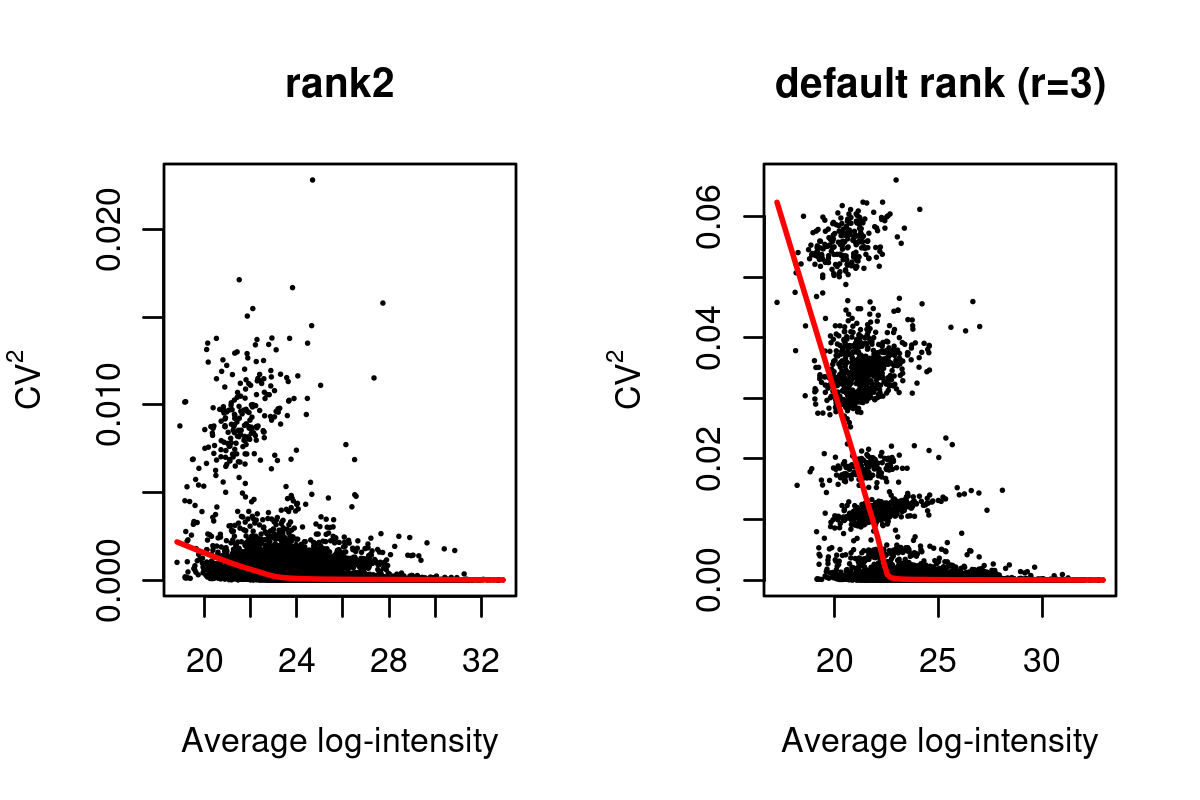

In [5]:
fig.size(4, 6)

y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       # a = 0.7, # alpha weights the random distribution - but this isn't really documented anywhere
                       method = "v2-mnar",
                       # method = "v2",
                       group = group,
                       gauss_shift = 3.8)

y_msImpute_defaultrank <- msImpute(y_dda[rowSums(!is.na(y_dda)) >= 4,], 
                       
                       method = "v2-mnar",
                       
                       group = group)




par(mfrow=c(1,2))
pcv <- plotCV2(y_msImpute, main = "rank2")
pcv <- plotCV2(y_msImpute_defaultrank, main = "default rank (r=3)")

In [6]:
##############################
#### Analysis in MSstats
##############################

##############################
## Load MSstats package
##############################
library(MSstats)

##############################
## Read MaxQuant report
##############################
# read in proteinGroups file, in order to use protein ids
proteinGroups<-read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/Ratio2.5_txt/txt/proteinGroups.txt", sep="\t", header=TRUE)

# Read in MaxQuant file: evidence.txt
infile <- read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/Ratio2.5_txt/txt/evidence.txt", sep="\t", header=TRUE)

# Read in annotation including condition and biological replicates
annot <- data.frame('Raw.file' = infile$Raw.file)
annot <- annot[!duplicated(annot$Raw.file),, drop = FALSE]
annot$Experiment <- targets$Experiment[match(annot$Raw.file, targets$Name)]
annot$Condition <- gsub('(.*)-(.*)', '\\1', annot$Experiment)
annot$BioReplicate <- gsub('(.*)-R([1-3])', '\\2', annot$Experiment)
annot$IsotopeLabelType <- 'L'


##############################
## Make MSstats required format
##############################
quant <- MaxQtoMSstatsFormat(evidence=infile, annotation=annot, proteinGroups=proteinGroups,
                             useUniquePeptide = TRUE,
                             summaryforMultipleRows = max,
                             removeProtein_with1Peptide=TRUE)

head(quant)


##############################
## dataProcess
## including Normalization, decide censored cutoff, protein-level summarization
##############################

## censoredInt='NA' for MaxQuant
processed.quant <- dataProcess(quant,
                               normalization = 'equalizeMedians',
                               summaryMethod="TMP",
                               cutoffCensored="minFeature",
                               censoredInt="NA",
                               MBimpute=TRUE,
                               maxQuantileforCensored=0.999)


y_msstats <- processed.quant$ProcessedData
y_msstats$peptide_id <- paste0(y_msstats$PEPTIDE,'_', y_msstats$PROTEIN)




y_msstats <- y_msstats[,c('peptide_id', 'originalRUN', 'ABUNDANCE')]
y_msstats <- tidyr::spread(y_msstats, 'originalRUN', 'ABUNDANCE')
rownames(y_msstats) <- y_msstats$peptide_id
y_msstats$peptide_id <- NULL





featurenames <- gsub('^_','', rownames(y_dda))




target_hits_msstats <- grep('upsedyp', rownames(y_msstats), value = TRUE)
target_hits_msstats <- gsub('(.*)\\;(.*)','\\1', target_hits_msstats)




target_hits <- grep('upsedyp', featurenames, value = TRUE)
length(target_hits)

dim(y_dda)
dim(y_msstats)


y_MLE <- impute.wrapper.MLE(y_dda)



y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)









y_qrilc <- impute.QRILC(y_dda, 1)[[1]]



sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD002370_Ratio2pt5_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])




mats <- list(
             "KNN"= y_knn,
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             "MSstats_AFT" = y_msstats,
             "baseline" = y_dda)





mats <- c(sOa_imps, mats)


** + Contaminant, + Reverse, + Only.identified.by.site, proteins are removed.

** Peptide and charge, that have 1 or 2 measurements across runs, are removed.

** 460 proteins, which have only peptide and charge in a protein, are removed among 2202 proteins.



,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
,<fct>,<fct>,<int>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,O00762upsedyp|UBE2C_HUMAN_upsedyp,FITPCYHPNVDTQGNICIDIIK,3,NA,NA,L,D,1,QEx2_000089,14143000
2,O00762upsedyp|UBE2C_HUMAN_upsedyp,GISAFPESDNIFK,2,NA,NA,L,D,1,QEx2_000089,91296000
3,O00762upsedyp|UBE2C_HUMAN_upsedyp,ISIEFPSGYPYNAPTVK,2,NA,NA,L,D,1,QEx2_000089,64119000
4,O00762upsedyp|UBE2C_HUMAN_upsedyp,TIIISIQSIIGEPNIDSPINTHAAEIWK,3,NA,NA,L,D,1,QEx2_000089,7354900
5,O00762upsedyp|UBE2C_HUMAN_upsedyp,WSAIYDVR,2,NA,NA,L,D,1,QEx2_000089,65398000
6,O00762upsedyp|UBE2C_HUMAN_upsedyp,WVGTIHGAAGTVYEDIR,2,NA,NA,L,D,1,QEx2_000089,NA


** Log2 intensities under cutoff = 16.908  were considered as censored missing values.

** Log2 intensities = NA were considered as censored missing values.

** Use all features that the dataset origianally has.



                       
  Summary of Features :
                         count
# of Protein              1742
# of Peptides/Protein     2-73
# of Transitions/Peptide   1-1
                      
  Summary of Samples :
                           C D
# of MS runs               3 3
# of Biological Replicates 3 3
# of Technical Replicates  1 1



 Summary of Missingness :


  # transitions are completely missing in at least one of the conditions : 166


    -> WVGTIHGAAGTVYEDIR_2_NA_NA, (ac)ASPDWGYDDK_NA_NA_NA, ESISVSSEQIAQFR_2_NA_NA, GGPFSDSYR_2_NA_NA, HDTSIKPISVSYNPATAK_2_NA_NA ...


  # run with 75% missing observations: 0



 == Start the summarization per subplot...



  |======================================================================| 100%



 == the summarization per subplot is done.



[1] 369

[1] 12568     6

[1] 13022     6

Cluster size 12568 broken into 2819 9749 
Cluster size 2819 broken into 2069 750 
Cluster size 2069 broken into 496 1573 
Done cluster 496 
Cluster size 1573 broken into 1503 70 
Cluster size 1503 broken into 885 618 
Done cluster 885 
Done cluster 618 
Done cluster 1503 
Done cluster 70 
Done cluster 1573 
Done cluster 2069 
Done cluster 750 
Done cluster 2819 
Cluster size 9749 broken into 3514 6235 
Cluster size 3514 broken into 770 2744 
Done cluster 770 
Cluster size 2744 broken into 1575 1169 
Cluster size 1575 broken into 749 826 
Done cluster 749 
Done cluster 826 
Done cluster 1575 
Done cluster 1169 
Done cluster 2744 
Done cluster 3514 
Cluster size 6235 broken into 3502 2733 
Cluster size 3502 broken into 1794 1708 
Cluster size 1794 broken into 828 966 
Done cluster 828 
Done cluster 966 
Done cluster 1794 
Cluster size 1708 broken into 819 889 
Done cluster 819 
Done cluster 889 
Done cluster 1708 
Done cluster 3502 
Cluster size 2733 broken into 850 1883 
Done cluster 85

### Differential Expression

In [7]:
n_ups <- 500
fdr_thresh <- 0.05


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   if(names(mats)[i] != "MSstats_AFT"){
     E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   }else{
     E <- mats[[i]]
   }
   
   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  rownames(tp) <- gsub('^_','', rownames(tp))
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh,1,0)
  
  
  tp$isUPS <- ifelse(grepl("upsedyp", rownames(tp)) , 1,0)
  
  
  tp$isUPS <- ifelse((rownames(tp) %in% target_hits) , 1,0)

  
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  


  fullTables[[names(mats)[i]]] <- data.frame(
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  TP_total = sum(tp$TP, na.rm = TRUE)
  FN_total = sum(tp$FN, na.rm = TRUE)
  FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
  if(names(mats)[i] == "MSstats_AFT"){
    FN_unestim_total = length(target_hits) - sum(TP_total, FN_total)
  }
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = FN_unestim_total
    
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0



fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       (Intercept) groupD
Down             0    298
NotSig           0  12039
Up           12568    231


processing Mice



       (Intercept) groupD
Down             0    351
NotSig           0  11936
Up           12568    281


processing EM



       (Intercept) groupD
Down             0    310
NotSig           0  12013
Up           12568    245


processing BPCA



       (Intercept) groupD
Down             0    328
NotSig           0  11977
Up           12568    263


processing KNN



       (Intercept) groupD
Down             0    274
NotSig           0  12126
Up           12568    168


processing impSeq



       (Intercept) groupD
Down             0    404
NotSig           0  11787
Up           12568    377


processing barycenter



       (Intercept) groupD
Down             0    313
NotSig           0  12097
Up           12568    158


processing MSstats_AFT



       (Intercept) groupD
Down             0    354
NotSig           0  12248
Up           13022    254


processing baseline



       (Intercept) groupD
Down             0    340
NotSig           0  11961
Up           12568    267


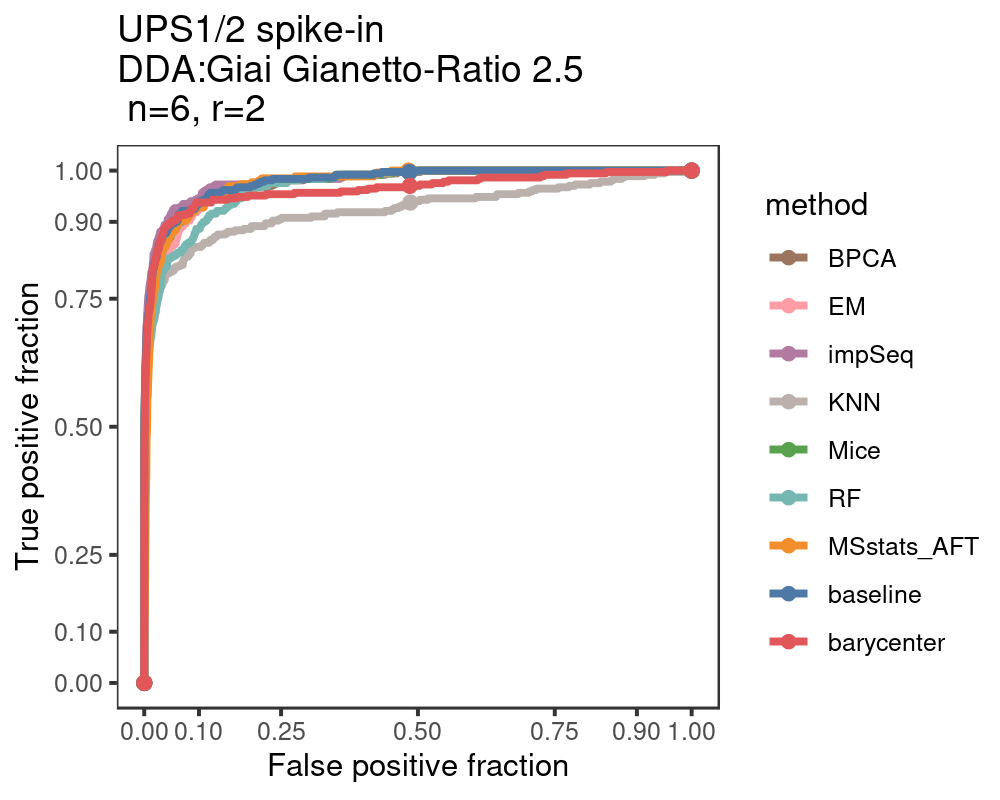

In [8]:
fig.size(4, 5)

library(plotROC)
library(ggthemes)


col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")

fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT","baseline","barycenter"))

p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide=FALSE) + 
  scale_color_manual(values = col_pal) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()
        #legend.position = 'None'
       ) # legend.position = 'None'




fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT",
                                        "baseline","barycenter"))

dataset_name = 'PXD002370Ratio2pt5'
print(p2 + labs(title = "UPS1/2 spike-in \nDDA:Giai Gianetto-Ratio 2.5\n n=6, r=2"))

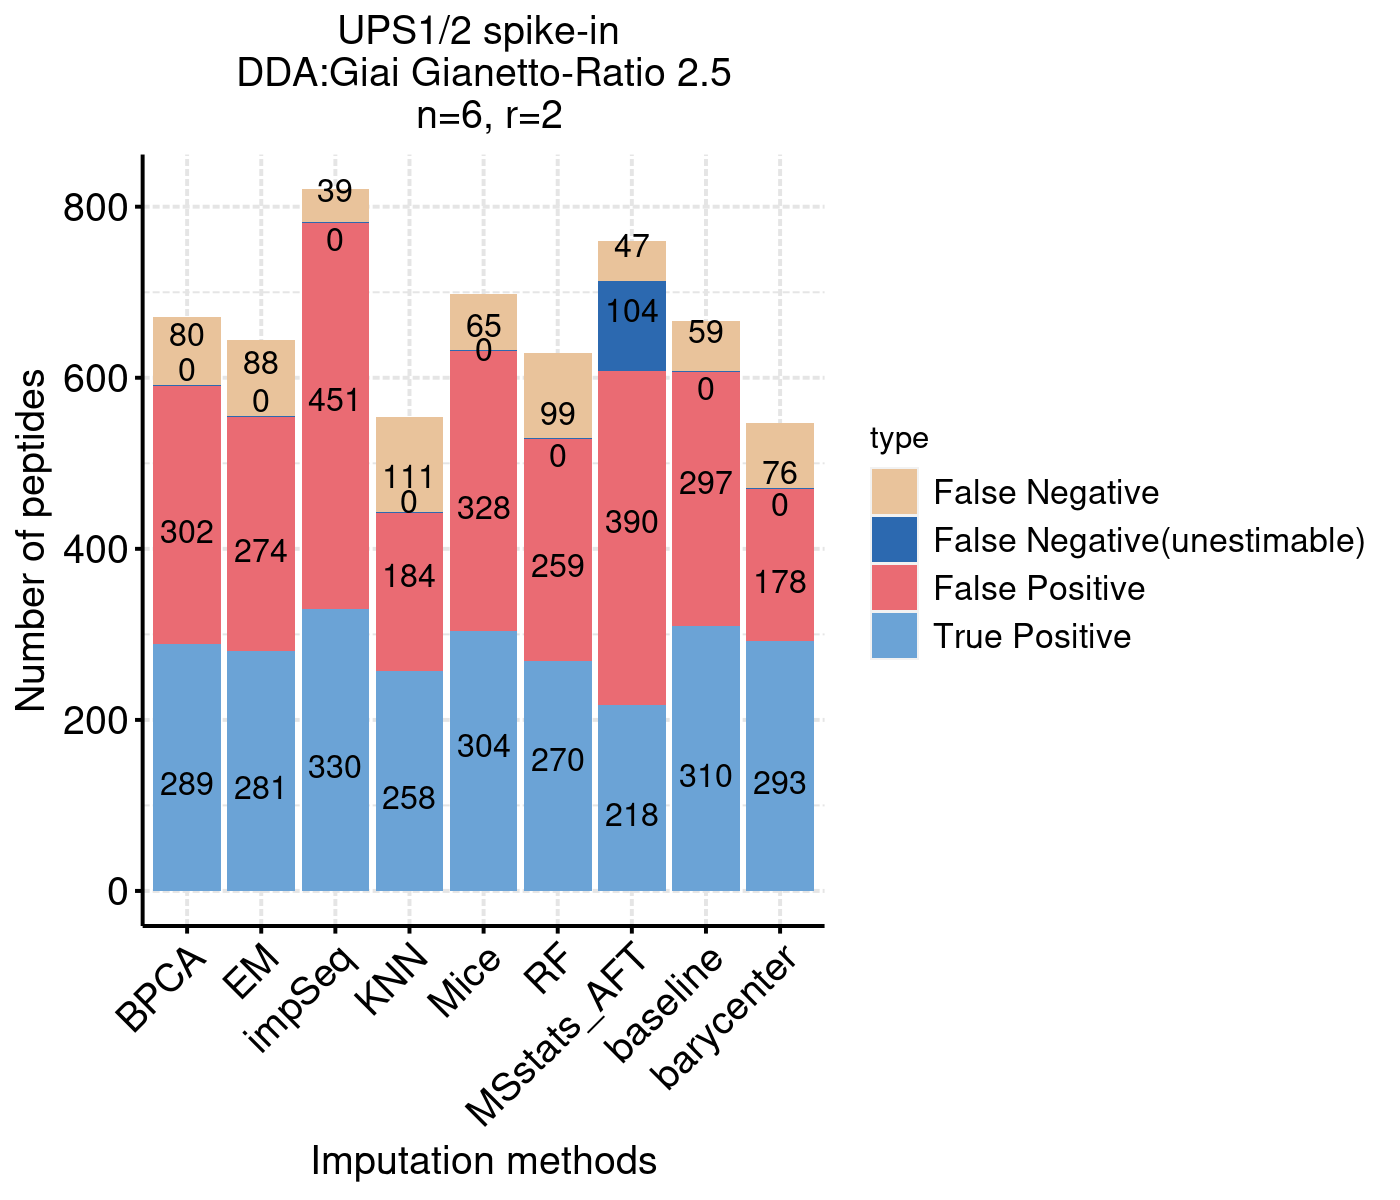

In [9]:
fig.size(6,7)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05

ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)


# png(file = "~/barplot_PXD002370_Ratio2pt5.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  
  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "UPS1/2 spike-in \nDDA:Giai Gianetto-Ratio 2.5\n n=6, r=2") +   

  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p

In [10]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types

hdp <- selectFeatures(y_dda[rowSums(!is.na(y_dda)) >= 4,],
                      method="ebm", group = group)

# hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))

png(file = "~/hist_missingtype_PXD002370_Ratio2pt5.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD002370-Ratio 2.5", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p

No NaN EBMs detected. Peptides are missing evenly across samples.

Switchted to 'hvp' method as final msImpute features




FALSE  TRUE 
12068   500 

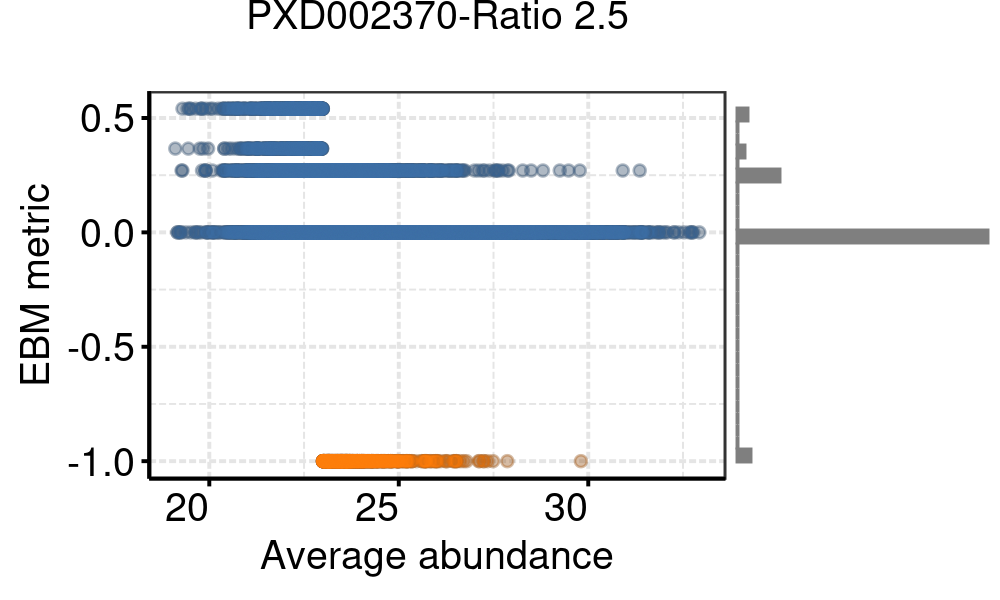

In [11]:
fig.size(3,5)

# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title = 'PXD002370-Ratio 2.5')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PXD002370_Ratio2pt5.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()

p1

No NaN EBMs detected. Peptides are missing evenly across samples.

Switchted to 'hvp' method as final msImpute features




FALSE  TRUE 
12068   500 

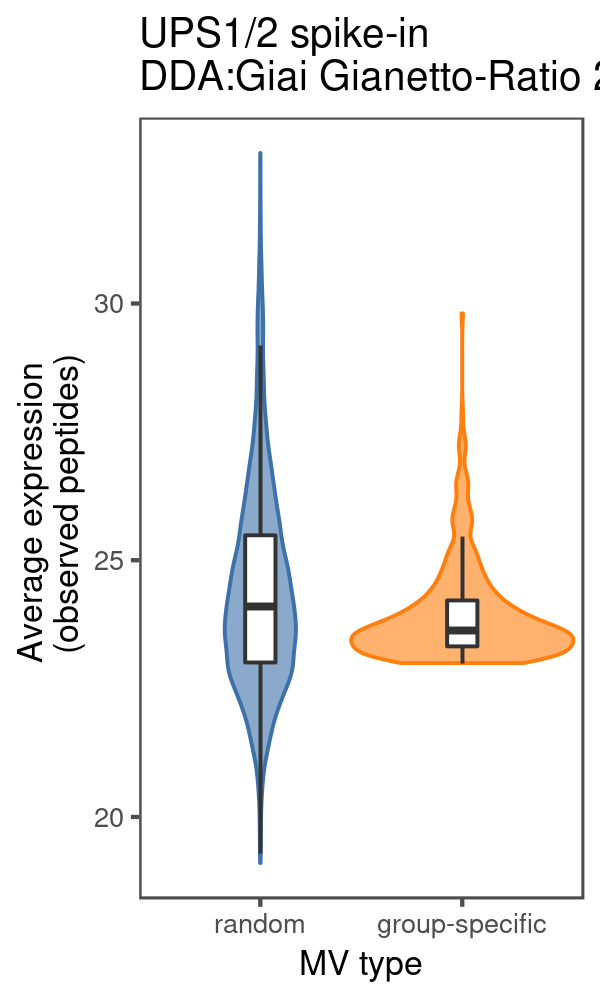

In [14]:
fig.size(5,3)

hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))



# png(file = paste0("revision_figures/violin_", dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +
  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average expression \n (observed peptides)', x = 'MV type',
       title = "UPS1/2 spike-in \nDDA:Giai Gianetto-Ratio 2.5") +
  theme_few() 

print(pv)
# dev.off()

### Session information

In [ ]:
sessionInfo()